# Deep Learning &mdash; Assignment 5

Fifth assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

**Note:**

* The models in this assignment take a while to train. It is faster on a GPU (e.g., on Google Colab), but still doable on a CPU. Plan ahead to leave enough time to analyse your results.

## Objectives

In this assignment you will
1. Implement an LSTM module from scratch.
2. Use the built-in LSTM module from PyTorch.
3. Compare fully connected and recurrent neural networks in an experiment.
4. Experiment with data augmentation.

## Import libraries

In [14]:
%matplotlib inline
import csv
import glob
import re
import time
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import torch
from IPython import display

# fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()

## 5.1 Dataset: Atrial fibrillation classification on ECG recordings (1 point)

In this assignment we will work with data from the [PhysioNet Computing in Cardiology Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) to classify atrial fibrillation in electrocardiograms (ECGs). Atrial fibrillation is an abnormal heart rhythm, which can be recognized as irregular patterns in ECG recordings.

**(a) Download the [training dataset](https://physionet.org/files/challenge-2017/1.0.0/training2017.zip) from the challenge website and extract the files.**

In [15]:
#!mkdir -p data
#!wget -c -O data/training2017.zip https://physionet.org/files/challenge-2017/1.0.0/training2017.zip
#!cd data/ ; unzip -qo training2017.zip

The dataset consists of a number of recordings and corresponding labels. We use a subset of the dataset that includes only the samples with a normal rhythm (label N or class 0) and those with atrial fibrillation (label A or class 1).

**(b) Run the code to load the data.**

In [16]:
class ECGDataset(torch.utils.data.Dataset):
    # labels: 'N', 'A', 'O'
    def __init__(self, directory, max_length=18286, class_labels=('N', 'A', 'O')):
        super().__init__()
        self.class_labels = class_labels
        self.load_data(directory, max_length)

    def load_data(self, directory, max_length):
        label_map = {}
        with open('%s/REFERENCE.csv' % directory, 'r') as f:
            for line in csv.reader(f):
                label_map[line[0]] = line[1]

        samples = []
        lengths = []
        labels = []

        for file in sorted(glob.glob('%s/*.mat' % directory)):
            subject_id = re.match(r'.+(A[0-9]+).mat', file)[1]
            label = label_map[subject_id]
            if label not in self.class_labels:
                # skip this label
                continue
            mat_data = scipy.io.loadmat(file)
            sample = mat_data['val'][0]
            if len(sample) < 4000:
                # skip short samples
                continue
            samples.append(np.pad(sample, (0, max_length - len(sample))))
            lengths.append(len(sample))
            labels.append(self.class_labels.index(label_map[subject_id]))

        # concatenate
        samples = np.vstack(samples)
        lengths = np.stack(lengths)
        labels = np.stack(labels)
        
        # convert to PyTorch tensors
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.lengths = torch.tensor(lengths, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    @property
    def class_proportions(self):
        return torch.mean((torch.arange(len(self.class_labels))[None, :] ==
                           self.labels[:, None]).to(torch.float), axis=0)
        
    def __getitem__(self, index):
        l = self.lengths[index]
        x = self.samples[index, :l]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.samples.shape[0]


data = ECGDataset('data/training2017', class_labels=('N', 'A'))

The recordings have different lengths (between 30 to 60 seconds). There are more "normal" recordings than recordings that show atrial fibrillation.

**(c) Print some statistics of the data.**

In [17]:
print('Number of examples: %d' % len(data))
print()
print('Minimum length: %d' % torch.min(data.lengths))
print('Median length:  %d' % torch.median(data.lengths))
print('Maximum length: %d' % torch.max(data.lengths))
print()
print('Class distribution:', data.class_proportions.numpy())

Number of examples: 5622

Minimum length: 4004
Median length:  9000
Maximum length: 18286

Class distribution: [0.87709    0.12290999]


Each example has a 1D vector that represents the ECG measurement over time.

**(d) Run the code to plot two recordings from each class.**

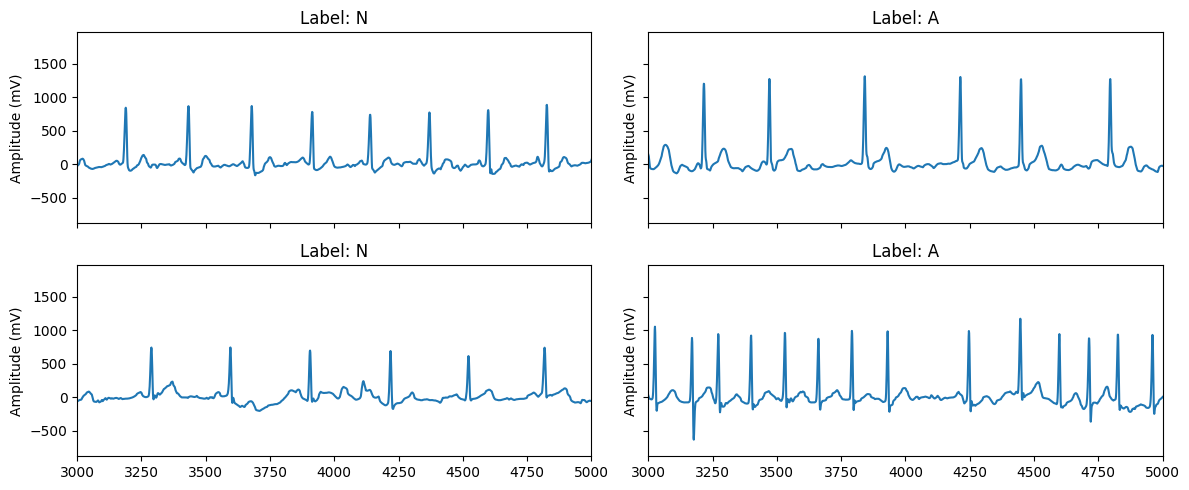

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data[idx]
    ax = axes[i // 2][i % 2]
    ax.plot(x)
    ax.set_title('Label: %s' % data.class_labels[y])
    ax.set_xlim(3000, 5000)
    ax.set_ylabel('Time (frames)')
    ax.set_ylabel('Amplitude (mV)')
plt.tight_layout()

**(e) The class distribution in this dataset is quite unbalanced. What consequences could this have?<span style="float:right"> (1 point)</span>**

Normal readings make up about 87% of the total samples so with guessing we can already get close to 90% accuracy. Additionally if we don't distribute the A class samples properly between train and validation we could have issues during training. False negatives for the unhealthy class may lead to more fatal outcomes so we may want to weight mistakes in this form more heavily by modifying the loss function. 

### Feature extraction

To simplify our poblem a bit, we will convert the 1D ECG signals to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram). A spectrogram is a summary of the frequencies in small windows of the recording. These features will make it easier to train a classification model.

**(f) Run the code to compute the spectrograms.**

In [19]:
class ECGSpectrumDataset(ECGDataset):
    NPERSEG = 32
    NOVERLAP = 32 // 8
    
    def __init__(self, *args, **kwargs):
        # initialize the original dataset to load the samples
        super().__init__(*args, **kwargs)
        # compute and store the spectrograms to replace the samples
        self.compute_spectrum()
    
    def compute_spectrum(self):
        """
        Replaces the samples in this dataset with spectrograms.
        """
        f, t, Sxx = scipy.signal.spectrogram(self.samples.numpy(), scaling='spectrum',
                                             nperseg=self.NPERSEG, noverlap=self.NOVERLAP)
        # normalize the measurements for each frequency
        Sxx = Sxx - np.mean(Sxx, axis=(0, 2), keepdims=True)
        Sxx = Sxx / np.std(Sxx, axis=(0, 2), keepdims=True)
        # replace the existing samples in the dataset with the computed spectrograms
        self.samples = torch.tensor(Sxx.transpose(0, 2, 1))
        # recompute the length of each samples to account for the number of windows
        self.lengths = (self.lengths - self.NPERSEG) // (self.NPERSEG - self.NOVERLAP)

data_spectrum = ECGSpectrumDataset('data/training2017', class_labels=('N', 'A'))  

**(g) Plot the spectrograms for the four samples from the previous plot.**

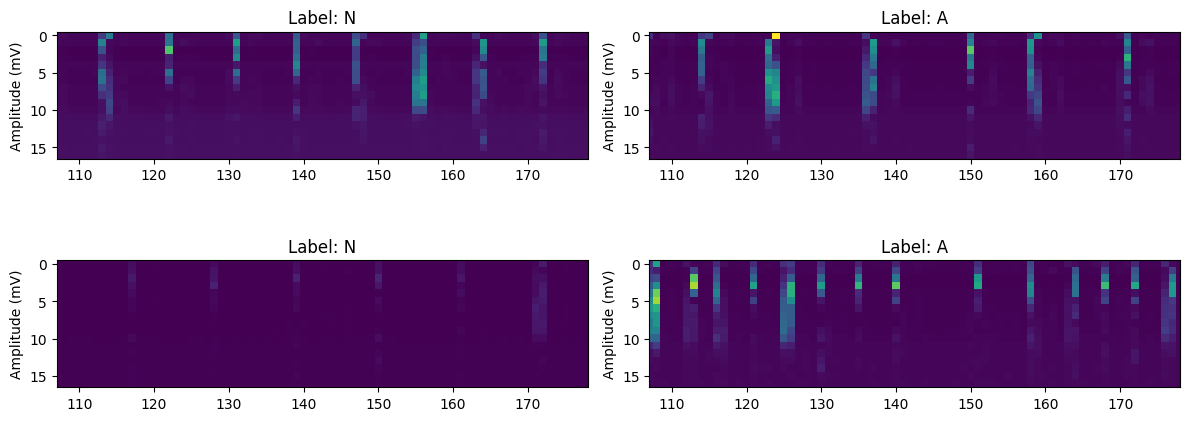

In [20]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data_spectrum[idx]
    plt.subplot(2, 2, i + 1)
    plt.imshow(x.T)
    plt.title('Label: %s' % data.class_labels[y])
    # show roughly the same segments as in the previous plot
    plt.xlim(3000 // 28, 5000 // 28)
    plt.ylabel('Amplitude (mV)')
plt.tight_layout()

The spectrogram data has 17 frequency bins for each window. We will use these as our input features. We normalized the data for each frequency to zero mean, unit variance.

**(h) Print the statistics of the spectrum dataset and check the shape of the first sample.**

In [21]:
print('Minimum length: %d' % torch.min(data_spectrum.lengths))
print('Median length:  %d' % torch.median(data_spectrum.lengths))
print('Maximum length: %d' % torch.max(data_spectrum.lengths))
print()
print('Mean value:         %f' % torch.mean(data_spectrum.samples))
print('Standard deviation: %f' % torch.std(data_spectrum.samples))
print()
# print the shape of the first sample
x, y = data_spectrum[0]
print('Shape of first sample:', x.shape)

Minimum length: 141
Median length:  320
Maximum length: 651

Mean value:         0.000327
Standard deviation: 1.003635

Shape of first sample: torch.Size([320, 17])


### Splitting training and validation sets

We will split our dataset in separate training and validation sets (80% &ndash; 20%).

**(i) Run the code to create a random split.**

In [22]:
train_samples = int(0.8 * len(data))
val_samples = len(data) - train_samples
data_train_original, data_val_original = torch.utils.data.random_split(data_spectrum, (train_samples, val_samples))

print('data_train:', len(data_train_original))
print('data_val:  ', len(data_val_original))

data_train: 4497
data_val:   1125


### Creating a balanced dataset by resampling

As you have seen, the dataset contains far more normal recordings than recordings with atrial fibrillation. We will create a balanced dataset by including multiple copies of the atrial fibrillation samples.

In this assignment we will also use a balanced validation set. This is something you may or may not want to do in practice, because it means that your validation set is no longer representative of the test data. The advantage is that the accuracy on a balanced validation set is easier to compare with the accuracy on the training set.

**(j) Run the code to create balanced training and validation sets.**

In [23]:
def balance_dataset(dataset):
    # collect labels from the source dataset
    labels = torch.zeros((len(dataset),), dtype=torch.long)
    for i, (x, y) in enumerate(dataset):
        labels[i] = y
    indices = torch.arange(len(dataset), dtype=torch.long)

    unique_labels = np.unique(labels.numpy())
    
    # count the number of samples per class
    n = [torch.sum((labels == label).to(torch.long)).item()
         for label in unique_labels]
    
    # perhaps the dataset is already balanced?
    if len(np.unique(n)) == 1:
        return dataset
    
    print('Samples per class:', n)
    for i, label in enumerate(unique_labels):
        # we will add more samples unless every class has the same number of samples
        while n[i] < max(n):
            extra_samples = max(n) - n[i]
            print('- Repeating %d samples for class %d' % (extra_samples, label))

            # take a random subset of samples from this class
            idxs = torch.where(labels == label)[0]
            idxs = idxs[torch.randperm(idxs.shape[0])]
            idxs = idxs[:extra_samples]

            # add these indices to the list
            indices = torch.cat((indices, idxs))
            n[i] += len(idxs)
    
    # return the subset as a new torch dataset
    return torch.utils.data.Subset(dataset, indices)

print('Balancing the training set')
data_train = balance_dataset(data_train_original)
print('Balancing the validation set')
data_val   = balance_dataset(data_val_original)

Balancing the training set
Samples per class: [3952, 545]
- Repeating 3407 samples for class 1
- Repeating 2862 samples for class 1
- Repeating 2317 samples for class 1
- Repeating 1772 samples for class 1
- Repeating 1227 samples for class 1
- Repeating 682 samples for class 1
- Repeating 137 samples for class 1
Balancing the validation set
Samples per class: [979, 146]
- Repeating 833 samples for class 1
- Repeating 687 samples for class 1
- Repeating 541 samples for class 1
- Repeating 395 samples for class 1
- Repeating 249 samples for class 1
- Repeating 103 samples for class 1


In [24]:
print(len(data_train))
print(len(data_val))

7904
1958


### Splitting recordings into chunks

The recordings in our dataset all have different lengths and are generally quite long. To simplify training, we will split them into smaller chunks of 40 time steps each. This means that each recording will have multiple chunks in the dataset.

**(k) Run the code to create the pre-chunked dataset.**

In [25]:
class ChunkedDataset(torch.utils.data.TensorDataset):
    def __init__(self, source_dataset, chunk_size=40):
        super().__init__()
        self.make_chunks(source_dataset, chunk_size)
    
    def make_chunks(self, source_dataset, chunk_size):
        all_x, all_y = [], []
        for x, y in source_dataset:
            for chunk in range(x.shape[0] // chunk_size):
                offset = chunk * chunk_size
                all_x.append(x[offset:offset + chunk_size])
                all_y.append(y)
        self.tensors = (torch.stack(all_x), torch.tensor(all_y))

chunked_data_train = ChunkedDataset(data_train_original)
chunked_data_val = ChunkedDataset(data_val_original)

# rebalance to compensate for any differences in length
chunked_data_train = balance_dataset(chunked_data_train)
chunked_data_val   = balance_dataset(chunked_data_val)

print('chunked_data_train:', len(chunked_data_train))
print('chunked_data_val:  ', len(chunked_data_val))

Samples per class: [33999, 4806]
- Repeating 29193 samples for class 1
- Repeating 24387 samples for class 1
- Repeating 19581 samples for class 1
- Repeating 14775 samples for class 1
- Repeating 9969 samples for class 1
- Repeating 5163 samples for class 1
- Repeating 357 samples for class 1
Samples per class: [8427, 1314]
- Repeating 7113 samples for class 1
- Repeating 5799 samples for class 1
- Repeating 4485 samples for class 1
- Repeating 3171 samples for class 1
- Repeating 1857 samples for class 1
- Repeating 543 samples for class 1
chunked_data_train: 67998
chunked_data_val:   16854


### Preparing data loaders

As in the previous assignments, we will use the PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) class to divide our datasets in minibatches.

**(l) Run the code to create the data loaders. Look at the shape of the first minibatch.**

In [26]:
batch_size = 192
chunked_loaders = {
    'train': torch.utils.data.DataLoader(chunked_data_train, shuffle=True, batch_size=batch_size),
    'val':   torch.utils.data.DataLoader(chunked_data_val, batch_size=batch_size),
}

# print the x and y shapes for one minibatch
for x, y in chunked_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([192, 40, 17]) torch.Size([192])


## 5.2 Implementing an LSTM (5 points)

Time series data such as the ECG recordings are a good target for recurrent neural network.

The class below implements an RNN layer in PyTorch, using the equations discussed in the lecture. See also
[section 9.4.2](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-networks-with-hidden-states) of the Dive into Deep Learning book.

**(a) Read through the code to see how the RNN works.**

In [27]:
class RNN(torch.nn.Module):
    """
    A simple recurrent neural network layer.

    Parameters:
       num_inputs:  scalar, the number of inputs to this module
       num_hiddens: scalar, the number of hidden units
    
    Input and output: see the forward function.
    """
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initializes the parameters of the RNN module.
        
        This initializes the bias vector b_h and weight matrices W_xh and W_hh.
        """
        # Helper function that constructs two weight matrices and a bias vector
        def triple():
            return (torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_hiddens))),
                    torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_hiddens, self.num_hiddens))),
                    torch.nn.Parameter(torch.zeros(size=(self.num_hiddens,))))

        # parameters for the rnn
        self.W_xh, self.W_hh, self.b_h = triple()

    def forward(self, inputs):
        """
        Computes the forward pass of the RNN module.
        
        Input:
           inputs:  a tensor of shape (samples, steps, input features)
                    giving the input for each sample at each step
        
        Output:
           outputs: a tensor of shape (samples, steps, hidden features)
                    providing the hidden values at the end of each step
           state:   a tuple (hiddens,)
                    the state of the RNN at the end of the last step,
                    with hiddens a tensor of shape (samples, hidden_features)
        """
        batch_size = inputs.shape[0]

        # initialize state
        state = (torch.zeros(size=(batch_size, self.num_hiddens),
                             dtype=inputs.dtype, device=inputs.device),)

        # run steps
        outputs = []
        for step in range(inputs.shape[1]):
            state = self.one_step(inputs[:, step], state)
            outputs.append(state[0])

        # concatenate outputs
        outputs = torch.stack(outputs, axis=1)
        return outputs, state

    def one_step(self, x, state):
        """
        Run a single step of the RNN module.
        
        Input:
           x:     a tensor of shape (samples, input features)
                  giving the input for each sample at the current step
           state: a tuple (hiddens,)
                  the state of the RNN at the end of the previous step,
                  with hiddens a tensor of shape (samples, hidden_features)
        """
        # extract current state
        (h,) = state

        # new hidden state
        h = torch.tanh(x @ self.W_xh + h @ self.W_hh + self.b_h)

        # return the state
        return (h,)

    def __repr__(self):
        return ('RNN(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
rnn = RNN(3, 5)
print(rnn)
print('Parameters:')
for name, param in rnn.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

assert rnn(torch.randn(2,10,3))[0].shape == torch.Size([2, 10, 5]), "The shape of the output is incorrect"
assert len(rnn(torch.randn(2,10,3))[1]) == 1, "The hidden state should have 1 element"
assert rnn(torch.randn(2,10,3))[1][0].shape == torch.Size([2, 5]), "The shape of the state is incorrect"

RNN(num_inputs=3, num_hiddens=5)
Parameters:
 - W_xh: (3, 5)
 - W_hh: (5, 5)
 - b_h: (5,)


The design of the LSTM module is more complex than that of the RNN, but it follows a similar pattern of looping over all steps in the input. You can use the RNN implementation as a basis for an LSTM module.

**(b) Implement the LSTM module below.<span style="float:right"> (5 points)</span>**

The equations and code on the slides, or in [d2l 10.1](http://d2l.ai/chapter_recurrent-modern/lstm.html) can provide some inspiration. Be aware that the d2l book uses `(steps, samples, ...)` instead of `(samples, steps, ...)` as the shapes for the input and output variables, so you probably cannot copy code directly. Use the RNN implementation above and adapt this to the LSTM equations from the book.

In [28]:
import torch.nn as nn

class LSTM(torch.nn.Module):
   


    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        #self.save_hyperparameters()

        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C = None):
        #print("This is the input shape:")
        #print(inputs.shape)
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[0], self.num_hiddens), device=inputs.device)
            C = torch.zeros((inputs.shape[0], self.num_hiddens), device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

    def __repr__(self):
        return ('LSTM(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
lstm = LSTM(3, 5)
print(lstm)
for name, param in lstm.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

assert len(list(lstm.parameters())) == 12, "There should be 12 parameters in an LSTM layer"
print(len(lstm(torch.randn(2,10,3))))
assert len(lstm(torch.randn(2,10,3))) == 2, "LSTM should return a tuple (output, state)"
assert len(lstm(torch.randn(2,10,3))[1]) == 2, "The hidden state should have 2 elements, h and c"
print(lstm(torch.randn(2,10,3))[1][0].shape)
print(lstm(torch.randn(3,10,3))[1][0].shape)
print("Output of forward:")
print(lstm(torch.randn(2,10,3))[1][0])
assert lstm(torch.randn(2,10,3))[1][0].shape == torch.Size([2, 5]), "The shape of the hidden state is incorrect"
assert lstm(torch.randn(2,10,3))[1][1].shape == torch.Size([2, 5]), "The shape of the hidden state is incorrect"

LSTM(num_inputs=3, num_hiddens=5)
 - W_xi: (3, 5)
 - W_hi: (5, 5)
 - b_i: (5,)
 - W_xf: (3, 5)
 - W_hf: (5, 5)
 - b_f: (5,)
 - W_xo: (3, 5)
 - W_ho: (5, 5)
 - b_o: (5,)
 - W_xc: (3, 5)
 - W_hc: (5, 5)
 - b_c: (5,)


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 0

## 5.3 Defining the training loop

As last week, we need to define some functions to run the train the models.

The code is essentially the same as in assignment 4.

**(a) Run the code to define the functions.**

In [ ]:
def accuracy(pred_y, true_y):
    # Computes the mean accuracy.
    if pred_y.shape[1] == 1:
        # binary classification
        correct = (pred_y[:, 0] > 0).to(true_y.dtype) == true_y
    else:
        # multi-class classification
        correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)

def evaluate(net, test_loader, loss_function=torch.nn.CrossEntropyLoss(), device=device):
    """
    Evaluate a model on the given dataset.
    Return loss, accuracy
    """
    with torch.no_grad():
        net.eval()
        metrics = Metrics(2)
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            acc = accuracy(pred_y, y)
            metrics.add(len(y), loss.item(), acc)
        return metrics.mean()

In [ ]:
class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train(net, data_loaders, num_epochs, lr=0.001, optimizer=torch.optim.Adam, device=device):
    """
    Train a network on the given data set.
    After every epoch compute validation loss and accuracy.
    """
    net.to(device)
    train_loader = data_loaders['train']
    num_batches = len(train_loader)
    optimizer = optimizer(net.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'train acc', 'val loss', 'val acc'])
    start_time = time.time()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        net.train()
        metrics = Metrics(2)
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            pred_y = net(x)
            loss = loss_function(pred_y, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                acc = accuracy(pred_y, y)
                metrics.add(len(y), loss.item(), acc)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss, train_acc = metrics.mean()
                plotter.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None, None))
        val_loss, val_acc = evaluate(net, data_loaders['val'], loss_function=loss_function, device=device)
        plotter.add(epoch + 1, (None, None, val_loss, val_acc))
    train_loss, train_acc = metrics.mean()
    train_time = time.time() - start_time
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')

## 5.4 Constructing some networks (5 points)

In the next experiments you will train different network architectures to see how they perform on the ECG dataset.

The input to all networks has the shape (samples, time steps, features) = (mb_size, 40, 17). The output should be a two features, shape (mb_size, 2), that will be used in a cross-entropy loss function. (The networks should not include the final softmax activation function.)

Some simple baselines:
* `FullyConnectedNet`: A simple fully connected network that takes all features.
* `MeanSpectrumNet`: A fully connected network that works on the mean spectrum over all time steps.

A convolutional network:
* `ConvNet`: This network does a convolution over the time steps, using the 17 input features as channels.

Some recurrent models:
* `RNNNet`: A recurrent network with a simple RNN module.
* `LSTMNet`: A recurrent network with a more advanced LSTM module.
* `TorchLSTMNet`: The same model, but using the PyTorch implementation of the LSTM.

### FullyConnectedNet

**(a) Check the implementation of the following baseline architecture:**

* Linear layer: network inputs to 512 units followed by a ReLU.
* Linear layer: 512 to 256 units followed by a ReLU.
* Linear layer: 256 to the network output.

In [ ]:
class FullyConnectedNet(torch.nn.Module):
    def __init__(self, inputs, outputs=2):
        super().__init__()

        # by defining these layers here, they are included in the
        # parameters() list of this module, so they can be trained
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(inputs, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        return self.net(x)

net = FullyConnectedNet(40 * 17)
print(net)

### MeanSpectrumNet

**(b) Check the implementation of the following baseline architecture:**

* Compute the mean spectrum (mean over the steps dimension).
* Linear layer: network inputs to 128 units followed by a ReLU.
* Linear layer: 128 to 64 units followed by a ReLU.
* Linear layer: 64 to the network output.

In [ ]:
class MeanSpectrumNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=2):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # compute the mean over all steps
        x = torch.mean(x, axis=1)
        return self.net(x)

net = MeanSpectrumNet()
print(net)

### ConvNet

**(c) Complete the implementation of the following architecture:<span style="float:right"> (1 point)</span>**

Convolution over the steps, using frequencies as channels:
* 1D-convolution: network inputs to 32 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 32 to 64 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 64 to 128 channels, kernel size 3, ReLU.
* `AdaptiveAvgPool1d(1)`: Compute the mean for each channel over all steps.
* Flatten.
* Linear layer: 128 to the network output.

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self, inputs=1, outputs=2):
        super().__init__()

        self.net = torch.nn.Sequential(
            # TODO add the convolutional and pooling layers
            
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(128, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # swap the steps and inputs dimensions, so we can convolve over
        # the steps use the frequencies as channels
        x = x.transpose(2, 1)
        return self.net(x)

net = ConvNet()

### RNNNet

**(d) Check the implementation of the following architecture:**

* RNN: network input to 128 hidden units.
* Use the final hidden state from the RNN.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [ ]:
class RNNNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=2):
        super().__init__()

        self.rnn = RNN(inputs, 128)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        out, (h,) = self.rnn(x)
        
        # use the final RNN hidden state as input
        # for the fully connected part
        return self.linear(h)

net = RNNNet()
print(net)

### LSTMNet

**(e) Implement the following architecture: (see RNNNet for an example)<span style="float:right"> (2 points)</span>**

* LSTM: network input to 128 hidden units.
* Use the final hidden state from the LSTM.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [ ]:
class LSTMNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=2):
        super().__init__()

        # TODO define the LSTM layer and the linear network
        #      (see RNNNet for an example)
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # TODO call the LSTM layer and then the linear network
        #      (see RNNNet for an example)

net = LSTMNet()
print(net)

### TorchLSTMNet

Implementing your own modules can be fun and good learning experience, but it is not always the most efficient solution. The built-in [LSTM implementation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) from PyTorch is much faster than our own version.

**(f) Implement a network similar to LSTMNet using the PyTorch torch.nn.LSTM module.<span style="float:right"> (2 points)</span>**

In [ ]:
class TorchLSTMNet(torch.nn.Module):
    # TODO make this identical to LSTMNet, but use torch.nn.LSTM
    #      instead of the LSTM layer you implemented yourself

net = TorchLSTMNet()
print(net)

## 5.5 Experiments

**(a) Train the models on the chunked dataset.**

You may change the parameters as you see fit, but document the changes you make.

In [ ]:
train(MeanSpectrumNet(), chunked_loaders, num_epochs=100, lr=0.001)

In [ ]:
train(FullyConnectedNet(40 * 17), chunked_loaders, num_epochs=25, lr=0.001)

In [ ]:
train(ConvNet(17), chunked_loaders, num_epochs=50, lr=0.01)

In [ ]:
train(RNNNet(17), chunked_loaders, num_epochs=50, lr=0.001)

In [ ]:
train(LSTMNet(17), chunked_loaders, num_epochs=25, lr=0.001)

In [ ]:
train(TorchLSTMNet(17), chunked_loaders, num_epochs=25, lr=0.001)

## 5.6 Discussion (11 points)

**(a) Briefly discuss and compare the performance of the models in your experiments. Which worked best and why?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

* *MeanSpectrumNet*:
* *FullyConnectedNet*:
* *ConvNet*:
* *RNNNet*:
* *(Torch)LSTMNet*:

**(b) Why do some of those models generalize better than others?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(c) How does your LSTM implementation compare with the PyTorch implementation?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(d) Your RNN model probably didn't work well. Why is that model more difficult to train than the LSTM?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(e) The convolutional network and the LSTM in these experiments both work on the time dimension. What is an advantage of the convolutional network over the LSTM?<span style="float:right"> (1 points)</span>**

TODO: Your answer here.

**(f) What is an advantage of the LSTM over a convolutional network?<span style="float:right"> (1 points)</span>**

TODO: Your answer here.

**(g) For reasons of speed, we used a fairly small window of 40 time steps. Suppose that we would make this window much larger. How do you think this would affect each model?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(h) One of the difficulties with recurrent networks is that inputs from early steps are quite far away from the final result. How would you suggest to reduce that problem?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## 5.7 Data augmentation

Especially if your dataset is small, data augmentation can help to improve the performance of your network.

We have an easy way to add some data augmentation to the ECG dataset. In our preprocessing, we divided each recording into small chunks of 40 time steps, which we then reused in every epoch. We can add more variation to the training set by creating chunks at random positions.

The [DataLoader](https://pytorch.org/docs/stable/data.html) class in PyTorch has a `collate_fn` parameter to which we can pass a function. This function is called for each minibatch in each epoch. We will use this to extract a random chunk from each sample.

The function `random_chunk_collate_fn` takes a minibatch of samples, chooses a random offset for each sample, extracts a small chunk at that position, and then concatenates and returns the result.

In [ ]:
def random_chunk_collate_fn(samples, window_size):
    # Take a list of tensors of (steps_i, features),
    # extract a random window of length window_size from each tensor,
    # concatenate to a tensor of shape (samples, window_size, features).
    x_batch = torch.empty((len(samples), window_size) + samples[0][0].shape[1:],
                          device=samples[0][0].device, dtype=samples[0][0].dtype)
    y_batch = torch.empty((len(samples),),
                          device=samples[0][1].device, dtype=samples[0][1].dtype)
    for i, (x, y) in enumerate(samples):
        # extract a random window
        offset = torch.randint(x.shape[0] - window_size, (1,))
        x_batch[i, :] = x[offset:offset + window_size]
        y_batch[i] = y
    return x_batch, y_batch

We construct a new DataLoader for our training set:

In [ ]:
# test to see the x and y shapes for one sample
random_chunk_loaders = {
    'train': torch.utils.data.DataLoader(data_train, shuffle=True, batch_size=batch_size,
                                         collate_fn=lambda s: random_chunk_collate_fn(s, window_size=40)),
    'val':   chunked_loaders['val']
}
for (x, y) in random_chunk_loaders['train']:
    print(x.shape, y.shape)
    break

Observe that the pre-chunked dataset was much larger than the new dataset with on-the-fly chunking. You might want to increase the number of training epochs a bit to make sure that the network sees a similar number of examples.

In [ ]:
print('Minibatches in chunked_loader[\'train\']:      ', len(chunked_loaders['train']))
print('Minibatches in random_chunk_loaders[\'train\']:', len(random_chunk_loaders['train']))

Let's see how this data augmentation method affects the performance of your networks.

**(a) Train the MeanSpectrumNet, FullyConnectedNet, ConvNet and TorchLSTMNet from the previous experiments on data from the `random_chunk_loaders`.**

In [ ]:
train(MeanSpectrumNet(), random_chunk_loaders, num_epochs=100, lr=0.001)

In [ ]:
train(FullyConnectedNet(40 * 17), random_chunk_loaders, num_epochs=100, lr=0.001)

In [ ]:
train(ConvNet(17), random_chunk_loaders, num_epochs=100, lr=0.001)

In [ ]:
train(TorchLSTMNet(17), random_chunk_loaders, num_epochs=100, lr=0.001)

## 5.8 Discussion (9 points)

**(a) How does the data augmentation influence the training and validation results? Can you explain this?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(b) Why does the data augmentation affect some models more than others?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(c) Should we also do data augmentation on the validation set? Why, or why not?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(d) Data augmentation is often a good way to add some domain knowledge to your model. Based on your knowledge of ECGs, why is (or isn't) our augmentation method a good idea?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

**(e) Give an example of another suitable augmentation method and explain why it would work for this data.<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(f) Give an example of an augmentation method that might be suitable for other data but would probably not work here. Explain why.<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 31 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 231feba / 2024-10-03</span>